In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
from MetaTrader5 import *
from datetime import datetime
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set(), sns.set_style('white')  
# Initializing MT5 connection 
MT5Initialize("C:\\Program Files\\MetaTrader 5\\terminal64.exe")
MT5WaitForTerminal()

print(MT5TerminalInfo())
print(MT5Version())

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

[2, 'MetaQuotes-Demo', '22911036']
[500, 2286, '18 Dec 2019']


## Standard econometric approach VS custom seasonal autocorrelation

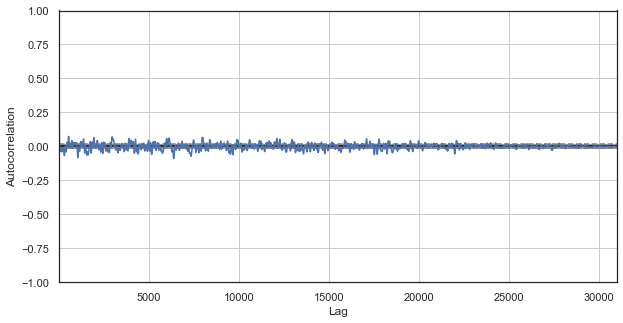

In [ ]:
def standard_autocorrelation(symbol, lag):
    rates = pd.DataFrame(MT5CopyRatesRange(symbol, MT5_TIMEFRAME_H1, datetime(2015, 1, 1), datetime(2020, 1, 1)), 
                         columns=['time', 'open', 'low', 'high', 'close', 'tick_volume', 'spread', 'real_volume'])
    rates = rates.drop(['open', 'low', 'high', 'tick_volume', 'spread', 'real_volume'], axis=1).set_index('time') 
    rates = rates.diff(lag).dropna()
    from pandas.plotting import autocorrelation_plot
    plt.figure(figsize=(10, 5))
    autocorrelation_plot(rates)

standard_autocorrelation('EURUSD', 50)

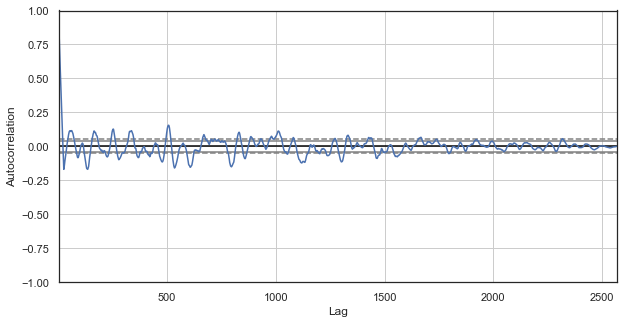

In [ ]:
def seasonal_autocorrelation(symbol, lag, hour1, hour2):
    rates = pd.DataFrame(MT5CopyRatesRange(symbol, MT5_TIMEFRAME_H1, datetime(2015, 1, 1), datetime(2020, 1, 1)), 
                         columns=['time', 'open', 'low', 'high', 'close', 'tick_volume', 'spread', 'real_volume'])
    rates = rates.drop(['open', 'low', 'high', 'tick_volume', 'spread', 'real_volume'], axis=1).set_index('time') 
    rates = rates.drop(rates.index[~rates.index.hour.isin([hour1, hour2])]).diff(lag).dropna()
    from pandas.plotting import autocorrelation_plot
    plt.figure(figsize=(10, 5))
    autocorrelation_plot(rates)

seasonal_autocorrelation('EURUSD', 25, 12, 13)

## Custom seasonal autocorrelation heatmap

,10,11,12,13,14
count,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000
mean,0.000470,0.000470,0.000472,0.000472,0.000478
std,0.037784,0.037774,0.037732,0.037693,0.037699
min,-0.221500,-0.227600,-0.222600,-0.221100,-0.216100
25%,-0.020500,-0.020705,-0.020800,-0.020655,-0.020600
50%,0.000100,0.000100,0.000150,0.000100,0.000250
75%,0.023500,0.023215,0.023500,0.023570,0.023420
max,0.213700,0.212200,0.210700,0.212600,0.208800


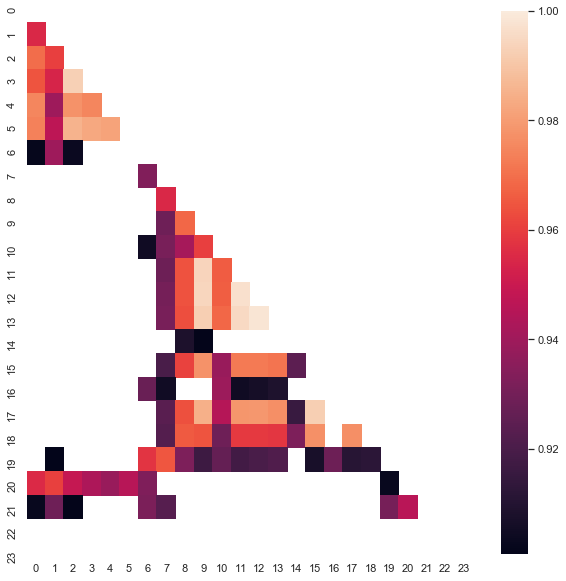

In [ ]:
#calculate correlation heatmap between all hours
def correlation_heatmap(symbol, lag, corrthresh):
    out = pd.DataFrame()
    rates = pd.DataFrame(MT5CopyRatesRange(symbol, MT5_TIMEFRAME_H1, datetime(2000, 1, 1), datetime(2020, 1, 1)), 
                         columns=['time', 'open', 'low', 'high', 'close', 'tick_volume', 'spread', 'real_volume'])
    rates = rates.drop(['open', 'low', 'high', 'tick_volume', 'spread', 'real_volume'], axis=1).set_index('time') 

    for i in range(24):
        ratesH = None
        ratesH = rates.drop(rates.index[~rates.index.hour.isin([i])]).diff(lag).dropna()
        out[str(i)] = ratesH['close'].reset_index(drop=True)
    plt.figure(figsize=(10, 10))
    corr = out.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr[corr >= corrthresh], mask=mask)
    return out

out = correlation_heatmap(symbol='EURUSD', lag=25, corrthresh=0.9)    
out[['10','11','12','13','14']].describe()

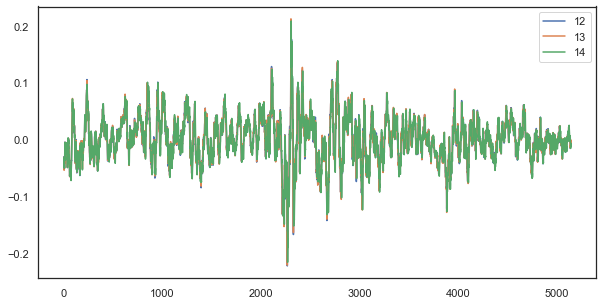

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(out[['12','13','14']])
plt.legend(out[['12','13','14']])
plt.show()

## Joinplots and formula for calculate returns forecast

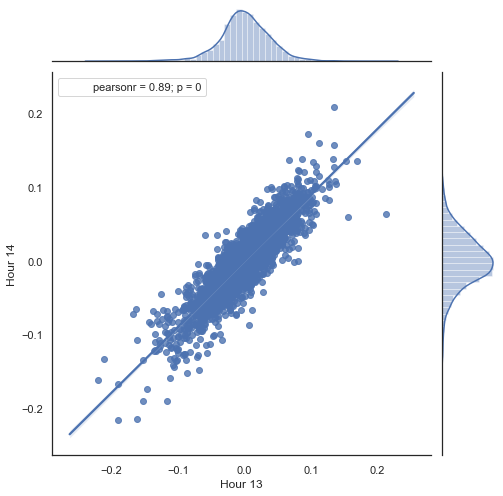

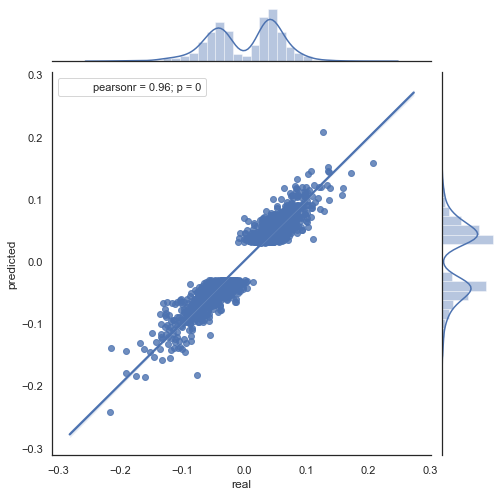

In [ ]:
# calculate joinplot between real an predicted returns
def hourly_signals_statistics(symbol, lag,  hour, hour2, rfilter):
    rates = pd.DataFrame(MT5CopyRatesRange(symbol, MT5_TIMEFRAME_H1, datetime(2000, 1, 1), datetime(2020, 1, 1)), 
                         columns=['time', 'open', 'low', 'high', 'close', 'tick_volume', 'spread', 'real_volume'])
    rates = rates.drop(['open', 'low', 'high', 'tick_volume', 'spread', 'real_volume'], axis=1).set_index('time')
# price differenсes for every hour series   
    H = rates.drop(rates.index[~rates.index.hour.isin([hour])]).reset_index(drop=True).diff(lag).dropna()
    H2 = rates.drop(rates.index[~rates.index.hour.isin([hour2])]).reset_index(drop=True).diff(lag).dropna()
# current returns for both hours    
    HF = H[1:].reset_index(drop=True); HL = H2[1:].reset_index(drop=True)     
# previous returns for both hours    
    HF2 = H[:-1].reset_index(drop=True); HL2 = H2[:-1].reset_index(drop=True)  
    
# Basic equation:  ret[-1] = ret[0] - (ret[lag] - ret[lag-1])
# or Close[-1] = (Close[0]-Close[lag]) - ((Close[lag]-Close[lag*2]) - (Close[lag-1]-Close[lag*2-1])) 

    predicted = HF-(HF2-HL2)
    real = HL 
# correlation joinplot between two series    
    outcorr = pd.DataFrame()
    outcorr['Hour ' + str(hour)] = H['close']
    outcorr['Hour ' + str(hour2)] = H2['close']
# real VS predicted prices     
    out = pd.DataFrame()
    out['real'] = real['close']
    out['predicted'] = predicted['close']
    out = out.loc[((out['predicted'] >= rfilter) | (out['predicted'] <=- rfilter))]
# plptting results    
    from scipy import stats
    sns.jointplot(x='Hour ' + str(hour), y='Hour ' + str(hour2), data=outcorr, kind="reg", height=7, ratio=6).annotate(stats.pearsonr) 
    sns.jointplot(x='real', y='predicted', data=out, kind="reg", height=7, ratio=6).annotate(stats.pearsonr)

hourly_signals_statistics('EURUSD', lag=25, hour=13, hour2=14, rfilter=0.03)

## 3D joinplots for actual and forecasted returns

In [ ]:
# calculate joinplot between real an predicted returns
def hourly_signals_statistics3D(symbol, lag,  hour, hour2, rfilter):
    rates = pd.DataFrame(MT5CopyRatesRange(symbol, MT5_TIMEFRAME_H1, datetime(2015, 1, 1), datetime(2020, 1, 1)), 
                         columns=['time', 'open', 'low', 'high', 'close', 'tick_volume', 'spread', 'real_volume'])
    rates = rates.drop(['open', 'low', 'high', 'tick_volume', 'spread', 'real_volume'], axis=1).set_index('time')
    rates = pd.DataFrame(rates['close'].diff(lag)).dropna()
    
    out = pd.DataFrame();
    for i in range(hour, hour2):
        H = None; H2 = None; HF = None; HL = None; HF2 = None; HL2 = None; predicted = None; real = None;
        H = rates.drop(rates.index[~rates.index.hour.isin([hour])]).reset_index(drop=True)
        H2 = rates.drop(rates.index[~rates.index.hour.isin([i+1])]).reset_index(drop=True)
        HF = H[1:].reset_index(drop=True); HL = H2[1:].reset_index(drop=True);     # current hours
        HF2 = H[:-1].reset_index(drop=True); HL2 = H2[:-1].reset_index(drop=True)  # last day hours
    
        predicted = HF-(HF2-HL2) # Close[-1] = (Close[0]-Close[1]) - ((Close[lag]-Close[lag+1]) - (Close[lag+1]-Close[lag+2])) or ret[-1] = ret[0] - (ret[lag] - ret[lag+1])
        real = HL 
    
        out3D = pd.DataFrame()
        out3D['real'] = real['close']
        out3D['predicted'] = predicted['close']
        out3D['predictedABS'] = predicted['close'].abs()
        out3D['hour'] = i
        out3D = out3D.loc[((out3D['predicted'] >= rfilter) | (out3D['predicted'] <=- rfilter))]
        
        out = out.append(out3D)
        
    import plotly.express as px
    fig = px.scatter_3d(out, x='hour', y='predicted', z='real', size='predictedABS', color='hour', height=1000, width=1000)
    fig.show()

hourly_signals_statistics3D('EURUSD', lag=24, hour=10, hour2=23, rfilter=0.000)